# Part 2.5: Technical Indicators & Signal Design

**Objective:** Implement a technical analysis system for S&P 500 stocks.

**Tasks:**

1. Compute technical indicators (SMA, EMA, RSI, MACD, ATR)

2. Generate entry/exit signals

3. Calculate signal-based portfolio weights

4. Evaluate signal-weighted portfolio and compare to equal-weight

**Deliverables:**

- Indicator matrix per ticker

- Signal matrix (Buy/Sell/Neutral)

- Signal-weighted portfolio returns and value

- Comparison with equal-weight strategy


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('seaborn-v0_8')

## Task 1: Compute Technical Indicators

In [2]:
# Load price data
prices = pd.read_csv(
    '../Part 1: Data Acquisition & Preprocessing/sp500_prices_5yr.csv', 
    index_col=0, 
    parse_dates=True)
tickers = list(prices.columns)

def sma(prices, period):
    return prices.rolling(window=period).mean()
def ema(prices, period):
    return prices.ewm(span=period, adjust=False).mean()
def rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
def macd(prices, fast=12, slow=26, signal=9):
    ema_fast = ema(prices, fast)
    ema_slow = ema(prices, slow)
    macd_line = ema_fast - ema_slow
    macd_signal = ema(macd_line, signal)
    return macd_line, macd_signal
def atr(prices, period=14):
    tr = prices.diff().abs()
    return tr.rolling(window=period).mean()
# Calculate indicators for all tickers
indicators = {}
for ticker in tickers:
    p = prices[ticker]
    indicators[ticker] = {
        'sma': sma(p, 20),
        'ema': ema(p, 12),
        'rsi': rsi(p, 14),
        'macd': macd(p, 12, 26, 9)[0],
        'macd_signal': macd(p, 12, 26, 9)[1],
        'atr': atr(p, 14)
    }
# Example: show first 5 rows for first ticker
pd.DataFrame({k: v for k, v in indicators[tickers[0]].items()}).head()

,sma,ema,rsi,macd,macd_signal,atr
Date,,,,,,
2020-08-07,NaN,108.203773,NaN,0.000000,0.000000,NaN
2020-08-10,NaN,108.445732,NaN,0.125460,0.025092,NaN
2020-08-11,NaN,108.148197,NaN,-0.038111,0.012451,NaN
2020-08-12,NaN,108.441027,NaN,0.116550,0.033271,NaN
2020-08-13,NaN,108.988444,NaN,0.391763,0.104969,NaN


## Task 2: Generate Entry/Exit Signals

In [3]:
signals = {}
for ticker in tickers:
    rsi_vals = indicators[ticker]['rsi']
    macd_vals = indicators[ticker]['macd']
    macd_signal_vals = indicators[ticker]['macd_signal']
    long = (rsi_vals < 30) & (macd_vals > macd_signal_vals)
    short = (rsi_vals > 70) & (macd_vals < macd_signal_vals)
    signal = pd.Series(0, index=rsi_vals.index)
    signal[long] = 1
    signal[short] = -1
    signals[ticker] = signal
# Create signal matrix
signal_matrix = pd.DataFrame(signals)
signal_matrix.head(5)

,AAPL,GOOG,GOOGL,AMZN,AVGO,BRK-B,COST,ABBV,BAC,CVX,...,ACGL,A,BR,BRO,DXCM,STZ,AWK,AEE,ADM,AVB
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-07,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Task 3: Calculate Signal-Based Portfolio Weights

In [4]:
base_weight = 0.1
weights = signal_matrix.apply(lambda x: base_weight * (1 + x), axis=1)
# Normalize weights to sum to 1.0
weights = weights.div(weights.sum(axis=1), axis=0)
weights.head()

,AAPL,GOOG,GOOGL,AMZN,AVGO,BRK-B,COST,ABBV,BAC,CVX,...,ACGL,A,BR,BRO,DXCM,STZ,AWK,AEE,ADM,AVB
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-07,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2020-08-10,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2020-08-11,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2020-08-12,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2020-08-13,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


## Task 4: Evaluate Signal-Weighted Portfolio and Compare

In [5]:
returns = prices.pct_change().dropna()
signal_portfolio_returns = (weights * returns).sum(axis=1)
equal_weight_returns = returns.mean(axis=1)
initial_value = 100000
signal_portfolio_value = initial_value * (1 + signal_portfolio_returns).cumprod()
equal_weight_value = initial_value * (1 + equal_weight_returns).cumprod()
# Show final values
print(f'Signal-weighted final: ${signal_portfolio_value.iloc[-1]:,.0f}')
print(f'Equal-weight final:    ${equal_weight_value.iloc[-1]:,.0f}')

Signal-weighted final: $233,710
Equal-weight final:    $245,108


## Deliverables
- **Indicator matrix**: See Task 1 output
- **Signal matrix**: See Task 2 output
- **Signal-weighted portfolio returns and value**: See Task 4 output
- **Comparison with equal-weight strategy**: See below

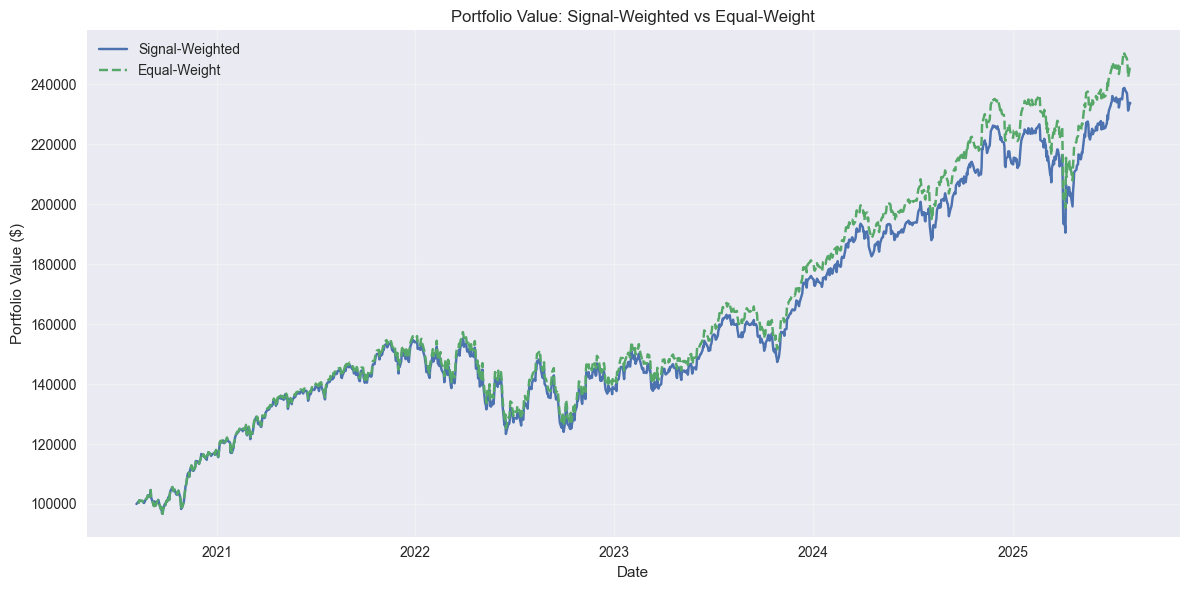

In [6]:
plt.figure(figsize=(12,6))
plt.plot(signal_portfolio_value, label='Signal-Weighted')
plt.plot(equal_weight_value, label='Equal-Weight', linestyle='--')
plt.title('Portfolio Value: Signal-Weighted vs Equal-Weight')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()